In [1]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import CONSTANT as cons


In [2]:
# def merge_parquet_files(folder_path, output_file):
#     files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".parquet")]
    
#     if not files:
#         print("No Parquet files found in the directory.")
#         return
    
#     schema = pq.ParquetFile(files[0]).schema_arrow
    
#     with pq.ParquetWriter(output_file, schema=schema) as writer:
#         for file in files:
#             table = pq.read_table(file, schema=schema)
#             writer.write_table(table)
    
#     print(f"Merged parquet file saved to {output_file}")

In [3]:
# folder_path = "/Users/Patron/Documents/hms/hms_data/train_eegs"
# output_file = "/Users/Patron/Documents/hms/hms_data/train_eeg.parquet"
# merge_parquet_files(folder_path, output_file)

In [4]:
train = pd.read_csv(cons.PATH_TO_TRAIN_CSV)
print(train.shape)
display(train.head())

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
df1 = pd.read_parquet(cons.PATH_TO_FILES_TRAIN_EEG+'568657.parquet')
print(f'There are {len(cons.FEATURES)} raw eeg features')
print(list(cons.FEATURES))

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [6]:
def plot_time_series(df, electrodes):
    plt.figure(figsize=(12, 6))
    offset = 0
    
    for i, col in enumerate(electrodes):
        if col in df.columns:
            x = df[col].values.astype('float32')
            m = np.nanmean(x)
            if np.isnan(x).mean() < 1:
                x = np.nan_to_num(x, nan=m)
            else:
                x[:] = 0
            
            if i != 0:
                offset += x.max()
            plt.plot(df.index, x - offset, label=col)
            offset -= x.min()
    
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.title('EEG Time Series Plot')
    plt.legend()
    plt.grid()
    plt.show()

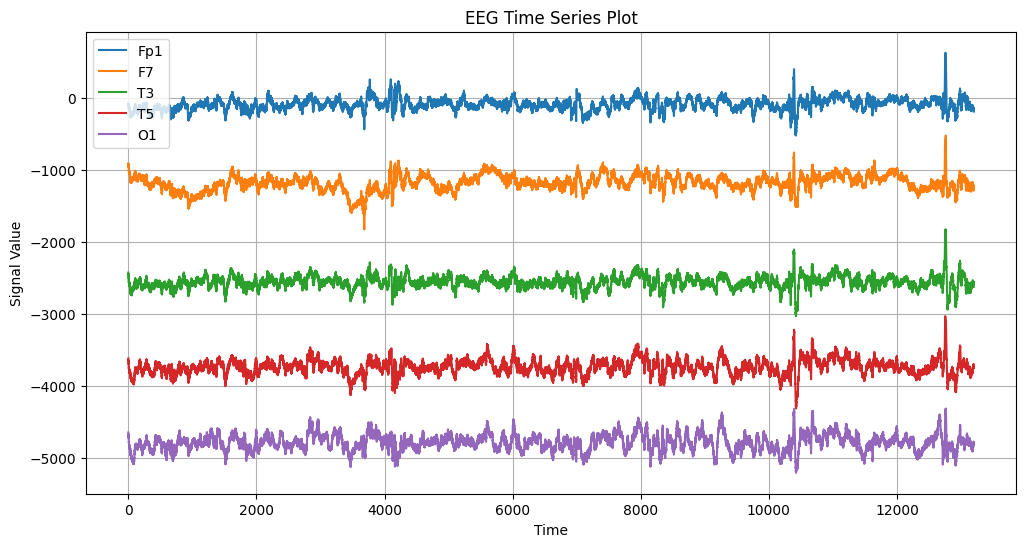

In [7]:
plot_time_series(df1, cons.LL)

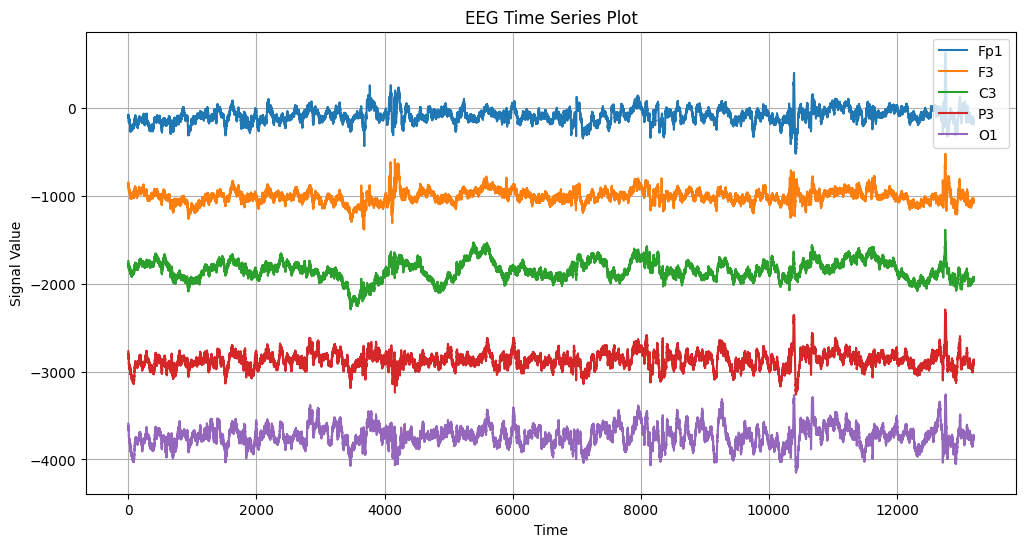

In [8]:
plot_time_series(df1, cons.LP)

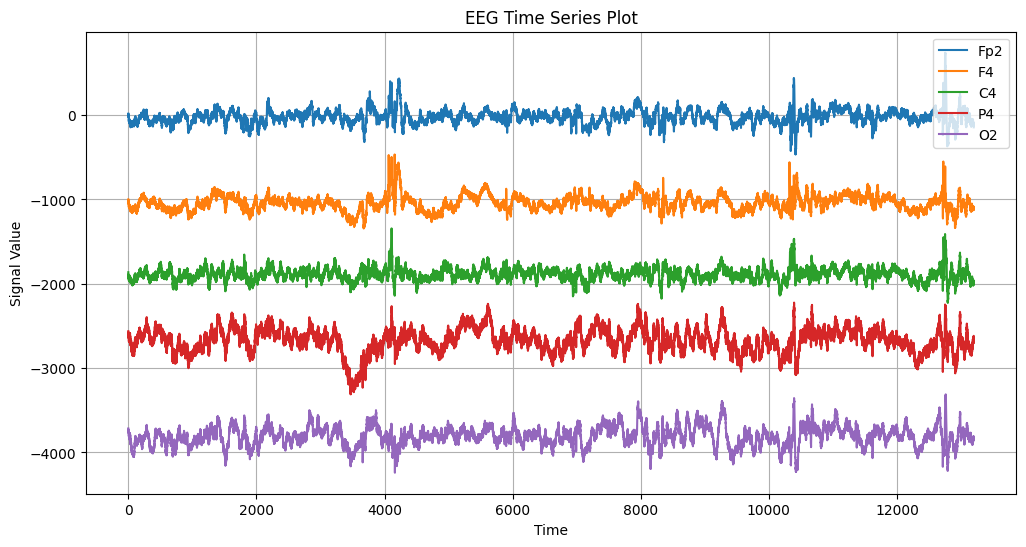

In [9]:
plot_time_series(df1, cons.RP)

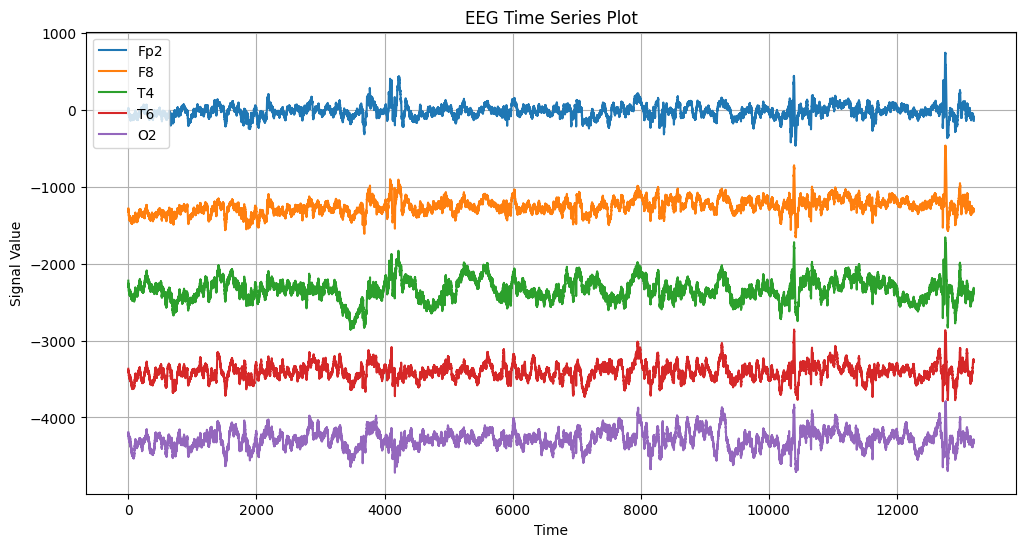

In [10]:
plot_time_series(df1, cons.RR)

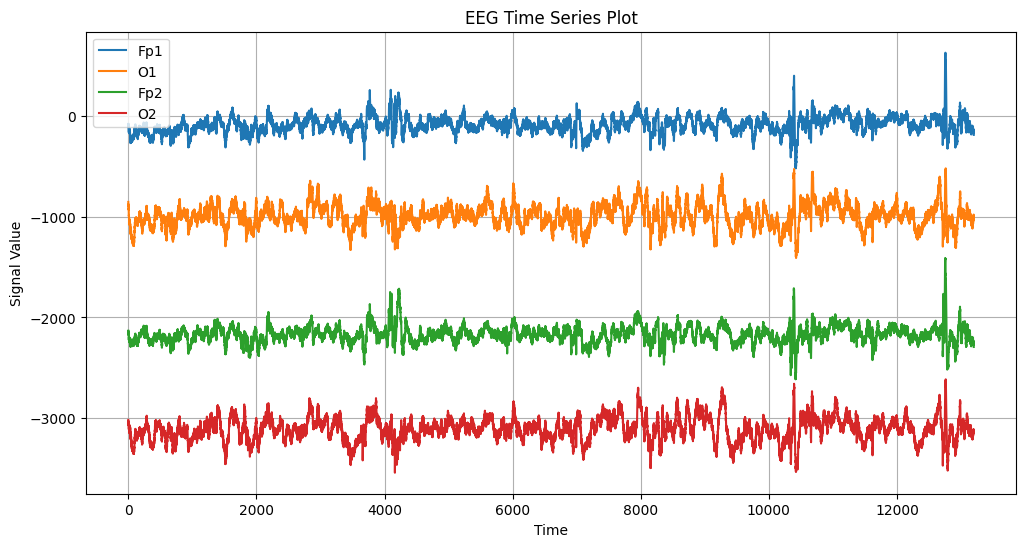

In [11]:
plot_time_series(df1, cons.IMPT_ELECTRODES)